# 卷积神经网络（LeNet）

在[“多层感知机的从零开始实现”](../chapter_3_deep-learning-basics/mlp-scratch.ipynb)一节里我们构造了一个含单隐藏层的多层感知机模型来对Fashion-MNIST数据集中的图像进行分类。每张图像高和宽均是28像素。我们将图像中的像素逐行展开，得到长度为784的向量，并输入进全连接层中。然而，这种分类方法有一定的局限性。

1. 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为$1,000$像素的彩色照片（含3个通道）。即使全连接层输出个数仍是256，该层权重参数的形状是$3,000,000\times 256$：它占用了大约3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：LeNet [1]。这个名字来源于LeNet论文的第一作者Yann LeCun。LeNet展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。

## LeNet模型

<font color='red'>LeNet分为卷积层块和全连接层块两个部分</font>。下面我们分别介绍这两个模块。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用$5\times 5$的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为$2\times 2$，且步幅为2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本<font color='red'>变平（flatten）</font>。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含3个全连接层。它们的输出个数分别是120、84和10，其中10为输出的类别个数。

下面我们通过`Sequential`类来实现LeNet模型。
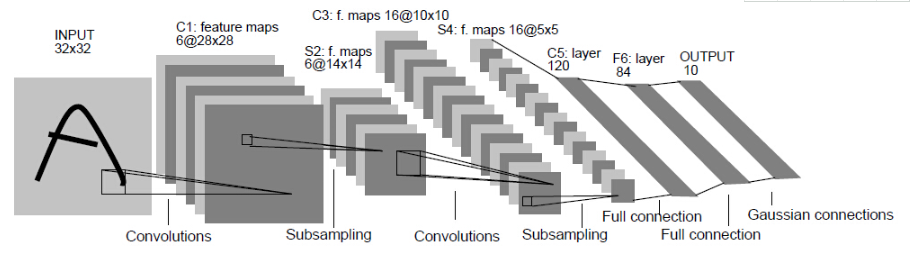

In [1]:
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn
import time

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # Dense会默认将(批量大小, 通道, 高, 宽)形状的输入转换成
        # (批量大小, 通道 * 高 * 宽)形状的输入
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

接下来我们构造一个高和宽均为28的单通道数据样本，并逐层进行前向计算来查看每个层的输出形状。

In [2]:
X = nd.random.uniform(shape=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 6, 24, 24)
pool0 output shape:	 (1, 6, 12, 12)
conv1 output shape:	 (1, 16, 8, 8)
pool1 output shape:	 (1, 16, 4, 4)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为5的卷积核，从而将高和宽分别减小4，而池化层则将高和宽减半，但通道数则从1增加到16。全连接层则逐层减少输出个数，直到变成图像的类别数10。


## 获取数据和训练模型

下面我们来实验LeNet模型。实验中，我们仍然使用Fashion-MNIST作为训练数据集。

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

因为卷积神经网络计算比多层感知机要复杂，建议使用GPU来加速计算。我们尝试在`gpu(0)`上创建`NDArray`，如果成功则使用`gpu(0)`，否则仍然使用CPU。

In [4]:
def try_gpu():  # 本函数已保存在d2lzh包中方便以后使用
    try:
        ctx = mx.gpu()
        _ = nd.zeros((1,), ctx=ctx)
    except mx.base.MXNetError:
        ctx = mx.cpu()
    return ctx

ctx = try_gpu()
ctx

cpu(0)

相应地，我们对[“softmax回归的从零开始实现”](../chapter_3_deep-learning-basics/softmax-regression-scratch.ipynb)一节中描述的`evaluate_accuracy`函数略作修改。由于数据刚开始存在CPU使用的内存上，当`ctx`变量代表GPU及相应的显存时，我们通过[“GPU计算”](../chapter_4_deep-learning-computation/use-gpu.ipynb)一节中介绍的`as_in_context`函数将数据复制到显存上，例如`gpu(0)`。

In [5]:
# 本函数已保存在d2lzh包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中
# 描述
def evaluate_accuracy(data_iter, net, ctx):
    acc_sum, n = nd.array([0], ctx=ctx), 0
    for X, y in data_iter:
        # 如果ctx代表GPU及相应的显存，将数据复制到显存上
        X, y = X.as_in_context(ctx), y.as_in_context(ctx).astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.size
    return acc_sum.asscalar() / n

我们同样对[“softmax回归的从零开始实现”](../chapter_3_deep-learning-basics/softmax-regression-scratch.ipynb)一节中定义的`train_ch3`函数略作修改，确保计算使用的数据和模型同在内存或显存上。

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx,
              num_epochs):
    print('training on', ctx)
    loss = gloss.SoftmaxCrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc,
                 time.time() - start))

我们重新将模型参数初始化到设备变量`ctx`之上，并使用Xavier随机初始化。损失函数和训练算法则依然使用交叉熵损失函数和小批量随机梯度下降。

In [8]:
lr, num_epochs = 0.9, 5
net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_ch5(net, train_iter, test_iter, batch_size, trainer, ctx, num_epochs)

training on cpu(0)
epoch 1, loss 2.3194, train acc 0.101, test acc 0.100, time 24.2 sec
epoch 2, loss 1.9063, train acc 0.262, test acc 0.552, time 24.0 sec
epoch 3, loss 0.9512, train acc 0.624, test acc 0.696, time 24.2 sec
epoch 4, loss 0.7512, train acc 0.707, test acc 0.738, time 23.5 sec
epoch 5, loss 0.6641, train acc 0.737, test acc 0.750, time 23.7 sec


## 小结

* 卷积神经网络就是含卷积层的网络。
* LeNet交替使用卷积层和最大池化层后接全连接层来进行图像分类。

## 练习

* 尝试基于LeNet构造更复杂的网络来提高分类准确率。例如，调整卷积窗口大小、输出通道数、激活函数和全连接层输出个数。在优化方面，可以尝试使用不同的学习率、初始化方法以及增加迭代周期。




## 参考文献

[1] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.